In [1]:
import sys
import os
sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))    # So can access functions in isca_tools which is in home/Isca directory
import isca_tools
from isca_tools.utils.moist_physics import rh_from_sphum
import metpy.calc
import metpy.constants
from metpy.units import units
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
# Load dataset
exp_name = 'play/rh_calc'
ds = isca_tools.load_dataset(exp_name)
namelist = isca_tools.load_namelist(exp_name)  # Need this for albedo_value
p_full = namelist['spectral_dynamics_nml']['reference_sea_level_press']     # pressure of entire atmosphere in Pa
ds_use = ds.sel(lon=[240.125], lat=[40.3], method="nearest")    # just consider one lat/lon coordinate
ds_use

<xarray.Dataset>
Dimensions:      (lon: 1, lonb: 65, lat: 1, latb: 33, time: 12, nv: 2)
Coordinates:
  * lon          (lon) float64 241.9
  * lonb         (lonb) float64 -2.812 2.812 8.438 14.06 ... 345.9 351.6 357.2
  * lat          (lat) float64 41.53
  * latb         (latb) float64 -90.0 -83.21 -77.61 -72.05 ... 77.61 83.21 90.0
  * time         (time) float64 15.0 45.0 75.0 105.0 ... 255.0 285.0 315.0 345.0
  * nv           (nv) float64 1.0 2.0
Data variables:
    sphum_2m     (time, lat, lon) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    temp_2m      (time, lat, lon) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    rh_2m        (time, lat, lon) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    ps           (time, lat, lon) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    average_T1   (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2   (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_DT   (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_bounds  (time, nv) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes:
    filename:   /gpfs1/scratch/other/jamd1/isca_work/experiment/play/rh_calc/...
    title:      FMS Model results
    grid_type:  regular
    grid_tile:  N/A

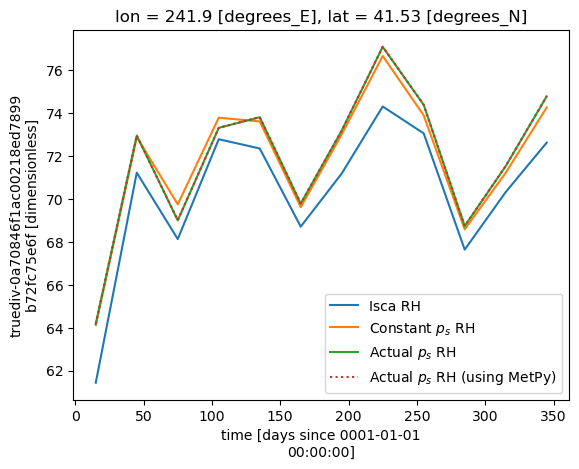

In [5]:
# Actual relative humidity
ds_use.rh_2m.plot(label='Isca RH')

# Relative humidity calculated with single surface pressure
rh_manual = rh_from_sphum(ds_use.sphum_2m, ds_use.temp_2m, p_full)
rh_manual.plot(label='Constant $p_s$ RH')

# Relative humidity calculated with actual surface pressure
rh_manual2 = rh_from_sphum(ds_use.sphum_2m, ds_use.temp_2m, ds_use.ps)
rh_manual2.plot(label='Actual $p_s$ RH')

# Relative humidity computed using Metpy - this is exactly the same as above using actual surface pressure
rh_metpy = metpy.calc.relative_humidity_from_specific_humidity(ds_use.ps * units.pascal, ds_use.temp_2m*units.kelvin,
                                                               ds_use.sphum_2m*units.kilogram/units.kilogram) * 100

rh_metpy.plot(label='Actual $p_s$ RH (using MetPy)', linestyle=':')
plt.legend();

From the above plot, we see that the 2m relative humidity computed by Isca is systematically larger than that obtained from the specific humidity and temperature values.

Isca computes the saturation vapour pressure using a lookup to values in the [Smithsonian tables](https://github.com/ExeClim/Isca/blob/9560521e1ba5ce27a13786ffdcb16578d0bd00da/src/shared/sat_vapor_pres/sat_vapor_pres.F90#L108-L111) so this may explain the difference.

Also, for this experiment (and most other examples on Isca), the option [`do_simple`](https://jduffield65.github.io/Isca/namelists/condensation/sat_vapor_pres/#do_simple) is set to `True` in the `sat_vapor_pres_nml` namelist. This could be another factor that may explain the difference.